In [1]:
from math import log, sqrt
import random
from typing import Optional, Self

import chess
import chess.pgn
from tqdm.notebook import tqdm

In [2]:
class Node:

    def __init__(self, board: chess.Board, parent: Optional[Self] = None):
        self.board = board
        self.parent = parent
        self.average_evaluation: float = 0
        self.visit_count: int = 0
        self.unexplored_moves = list(board.legal_moves)
        random.shuffle(self.unexplored_moves)
        self.children: dict[chess.Move, Self] = {}
    
    def is_leaf(self) -> bool:
        """Checks is the node is a leaf of the search tree, i.e., has unexplored moves left to add to the tree."""
        return len(self.unexplored_moves) != 0
    
    def is_terminal(self) -> bool:
        """Checks if the node is terminal, i.e., is in a postion from which there are no legal moves."""
        return len(self.unexplored_moves) == 0 and len(self.children) == 0
    
    def __repr__(self):
        move_string = str(chess.pgn.Game.from_board(self.board)).split("\n")[-1]
        return f"<Node V={self.visit_count} M={self.average_evaluation:.4f} moves=\"{move_string}\">"


UCT_EXPLORATION_CONSTANT = sqrt(2)
def uct(node, parent) -> float:
    if node.visit_count == 0:
        return float("inf")
    return node.average_evaluation + UCT_EXPLORATION_CONSTANT * sqrt(log(parent.visit_count) / node.visit_count)


def select(node) -> Node:
    if node.is_leaf() or node.is_terminal():
        return node
    
    child = max(node.children.values(), key=lambda c: uct(c, node))
    assert child is not None, "Failed to filter childless nodes in recursion anchor"
    
    return select(child)


def expand(node: Node) -> Node:
    while len(node.unexplored_moves) > 0:
        move = node.unexplored_moves.pop()
        child_board = node.board.copy()
        child_board.push(move)

        child = Node(child_board)
        child.parent = node
        node.children[move] = child

    return child

payouts = {
    None: 0.5,
    chess.WHITE: 1,
    chess.BLACK: 0,
}
def simulate(node) -> float:
    board = node.board.copy()
    outcome = board.outcome(claim_draw=True)
    while outcome is None:
        move = random.choice(list(board.legal_moves))
        board.push(move)
        outcome = board.outcome(claim_draw=True)
    return payouts[outcome.winner]

def backpropagate(node, payout):
    node.average_evaluation = (node.average_evaluation * node.visit_count + payout) / (node.visit_count + 1)
    node.visit_count += 1
    if node.parent is not None:
        backpropagate(node.parent, payout)

In [3]:
if "root" not in dir():
    root = Node(chess.Board())
# root = Node(chess.Board("rnbqkbnr/p2p1ppp/1p6/2p1p2Q/2B1P3/8/PPPP1PPP/RNB1K1NR w KQkq - 0 1"))
for i in tqdm(range(1000)):
    node = select(root)
    if len(node.unexplored_moves) > 0 and node.visit_count > 0:
        node = expand(node)
    payout = simulate(node)
    backpropagate(node, payout)

  0%|          | 0/500000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [5]:
sorted_openings = sorted(root.children.items(), key=lambda t: t[1].visit_count, reverse=True)
total_visits = sum(child.visit_count for child in root.children.values())
for move, child in sorted_openings:
    node = child
    while len(node.children) > 0:
        node = max(node.children.values(), key=lambda n: n.visit_count)
    move_string = str(chess.pgn.Game.from_board(node.board)).split("\n")[-1]
    print(f"{child.visit_count / total_visits * 100 :.2f}% : {move_string}")

5.69% : 1. g3 b5 2. b4 e5 3. Bh3 *
5.64% : 1. g4 f5 2. f3 h5 3. e3 *
5.56% : 1. b4 b6 2. Nc3 Nc6 3. a3 *
5.36% : 1. h4 f6 2. Nh3 Na6 3. Ng5 *
5.17% : 1. b3 Nc6 2. Bb2 f5 3. e4 *
5.16% : 1. e4 f6 2. a3 g5 3. Ra2 *
5.16% : 1. a3 d5 2. Nh3 a5 3. Ng1 *
5.13% : 1. a4 d6 2. h4 g6 3. g4 *
5.12% : 1. h3 Nh6 2. Nc3 g5 3. a3 *
5.06% : 1. f3 f6 2. Nh3 a6 3. Nc3 *
4.97% : 1. Nh3 g5 2. e4 f6 3. Na3 *
4.96% : 1. Nf3 Nh6 2. Ng5 Na6 3. Nxf7 *
4.80% : 1. d3 e6 2. Nh3 Ne7 3. Bh6 *
4.79% : 1. Nc3 b5 2. Nh3 f5 3. Ng5 *
4.76% : 1. Na3 c6 2. e4 h5 3. h4 *
4.74% : 1. c3 f6 2. g4 a5 3. c4 *
4.73% : 1. c4 d6 2. h4 Nh6 3. d3 *
4.54% : 1. d4 b5 2. d5 g5 3. Na3 *
4.41% : 1. e3 e6 2. Qe2 Qf6 3. Qc4 *
4.24% : 1. f4 g5 2. Nf3 g4 3. c3 *


In [6]:
for move, child in sorted(root.children.items(), key=lambda t: t[1].visit_count, reverse=True):
    print(f"{root.board.san(move):>5} average = {child.average_evaluation:+.4f} UCT={uct(child, child.parent)}")

   g3 average = +0.5016 UCT=0.5370721727002977
   g4 average = +0.5015 UCT=0.5370727198725749
   b4 average = +0.5012 UCT=0.5370848588867382
   h4 average = +0.5005 UCT=0.5370709539326483
   b3 average = +0.4999 UCT=0.5370675362803221
   e4 average = +0.4998 UCT=0.53708546515187
   a3 average = +0.4998 UCT=0.5370633400336096
   a4 average = +0.4997 UCT=0.5370699089849229
   h3 average = +0.4997 UCT=0.5370847908278736
   f3 average = +0.4995 UCT=0.5370654438104929
  Nh3 average = +0.4991 UCT=0.537067517654189
  Nf3 average = +0.4991 UCT=0.5370801247682528
   d3 average = +0.4985 UCT=0.5370773932404613
  Nc3 average = +0.4984 UCT=0.5370565066494449
  Na3 average = +0.4983 UCT=0.5370617619009908
   c3 average = +0.4982 UCT=0.5370576351519295
   c4 average = +0.4982 UCT=0.5370795133184217
   d4 average = +0.4974 UCT=0.5370845910117067
   e3 average = +0.4968 UCT=0.537072562426989
   f4 average = +0.4960 UCT=0.5370852575489803


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

/tmp/ipykernel_120504/2160802804.py:2: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.sqrt(np.log(v + 1) / v))


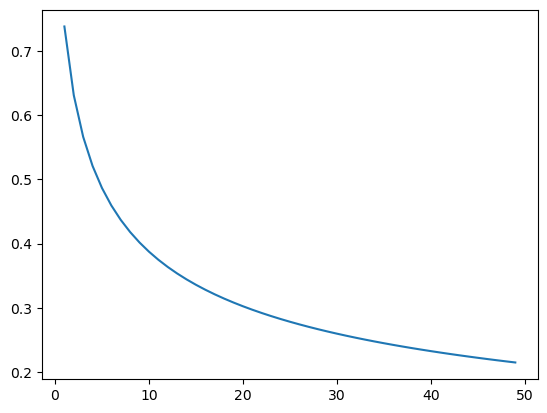

In [ ]:
v = np.linspace(0, 100)
plt.plot(np.sqrt(np.log(v + 1) / v))